In [1]:
# In order to force the reload of modules
# %load_ext autoreload
# %autoreload 2

# In order to make the import of local modules
import sys
sys.path.append('../..')

import abc
from collections import *
from dataclasses import dataclass
import enum
import gym
import heapq
import numpy as np
import random
from typing import *

import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
from tqdm import tqdm, trange

from ml.rl.core import *

%matplotlib inline
import imageio
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
"""
Trying the agent on cartpole
"""


def try_agent(agent: Agent):
    with gym.make("CartPole-v0") as env:
        total_reward = 0.0
        obs = env.reset()
        env.render()
        done = False
        while not done:
            action = agent.get_action(env, obs)
            obs, reward, done, _ = env.step(action)
            total_reward += reward
            env.render()
        print("Total reward {0:.2f}".format(total_reward))


"""
Random agent
"""

class RandomAgent(Agent):
    def get_action(self, env, state):
        return env.action_space.sample()


try_agent(RandomAgent())

Total reward 9.00


In [3]:
"""
Manual agent (does not take account of speed)
"""


class BrutalAgent(Agent):
    def get_action(self, env, state):
        x, x_dot, theta, theta_dot = state
        if theta < 0.02:
            return 0
        elif theta > 0.02:
            return 1
        return 0


try_agent(BrutalAgent())

Total reward 40.00


In [4]:
"""
Application of PID circuit (limited to linear systems)
"""


# How you do it in the industry
print("TODO")

TODO


Mean score: 19.75
Mean score: 17.5625
Mean score: 43.6875
Mean score: 36.0
Mean score: 68.0625
Mean score: 108.0
Mean score: 128.9375
Mean score: 149.4375
Mean score: 178.0625
Mean score: 184.3125
Mean score: 190.5
Mean score: 183.6875
Mean score: 190.375
Mean score: 196.9375
Mean score: 195.1875
Mean score: 191.25
Mean score: 179.9375
Mean score: 190.5
Mean score: 185.6875
Mean score: 200.0
Solved!


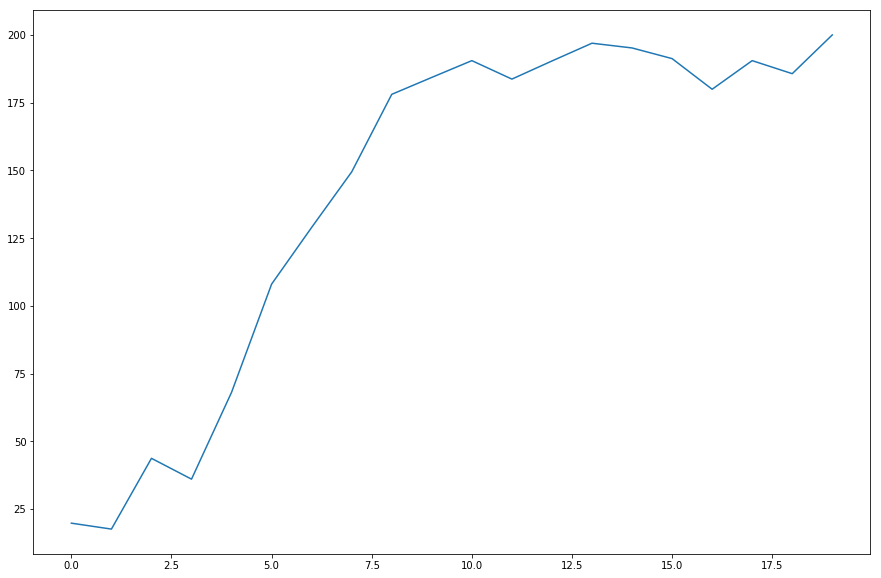

In [5]:
"""
Cross Entropy Method:
- Start with a random policy
- Play N episodes with the current policy
- Take the episodes above a reward boundary (typically percentile 70th)
- Train on these "Elite" episodes (throw away the uninteresting ones)
=> Look like a kind of genetic algorithm stuff
"""


from ml.rl.cross_entropy_method import *


"""
Implementation of a policy to learn via a Neural Net
"""


class FullyConnectedNet(nn.Module):
    def __init__(self, observation_size, hidden_size, action_size):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(observation_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size))
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, observations, with_softmax = False):
        ys = self.fc(observations)
        if with_softmax:
            return self.softmax(ys)
        return ys
    

"""
Test with the policy of a neural net
"""


fc_net = FullyConnectedNet(observation_size=4, hidden_size=100, action_size=2)
policy = NeuralNetPolicy(iteration_nb=5, learning_rate=0.1, net=fc_net)
agent = CrossEntropyAgent(policy)
with gym.make("CartPole-v0") as env:
    scores = agent.fit(env, max_iteration = 100, batch_size = 16, batch_threshold = 0.7)

plt.figure(figsize=(15, 10))
plt.plot(scores)
plt.show()

Mean score: 17.4375
Mean score: 20.5625
Mean score: 26.5625
Mean score: 31.0625
Mean score: 43.25
Mean score: 45.875
Mean score: 71.0
Mean score: 99.375
Mean score: 102.4375
Mean score: 103.625
Mean score: 166.625
Mean score: 181.875
Mean score: 171.9375
Mean score: 168.75
Mean score: 171.3125
Mean score: 171.5625
Mean score: 196.9375
Mean score: 182.3125
Mean score: 176.375
Mean score: 196.625
Mean score: 191.0625
Mean score: 192.875
Mean score: 200.0
Solved!


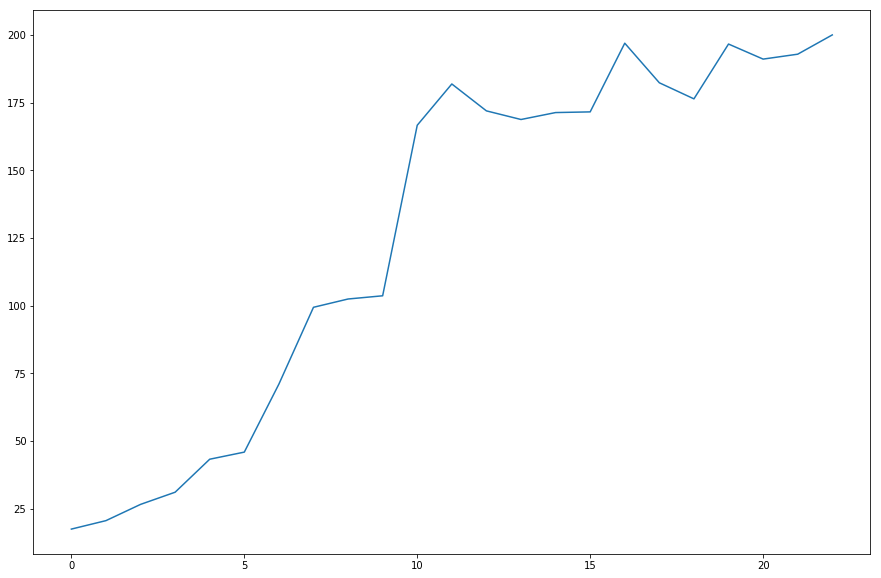

In [7]:
class PolynomialRegressionNet(nn.Module):
    def __init__(self, observation_size, action_size):
        super().__init__()
        feature_size = self._transform(torch.zeros(observation_size)).shape[0]
        self.fc = nn.Linear(feature_size, action_size)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, observations, with_softmax=False):
        if len(observations.shape) == 2:
            xs = torch.stack([self._transform(observation) for observation in observations])
        else:
            xs = self._transform(observations)
        ys = self.fc(xs)
        if with_softmax:
            return self.softmax(ys)
        return ys
    
    def _transform(self, observation):
        xs = list(observation)
        k = len(observation)
        for i in range(k-1):
            for j in range(i+1, k):
                xs.append(observation[i] * observation[j])
        return torch.FloatTensor(xs)
    

"""
Test with the policy of a neural net
"""


fc_net = PolynomialRegressionNet(observation_size=4, action_size=2)
policy = NeuralNetPolicy(iteration_nb=5, learning_rate=0.1, net=fc_net)
agent = CrossEntropyAgent(policy)
with gym.make("CartPole-v0") as env:
    scores = agent.fit(env, max_iteration = 100, batch_size = 16, batch_threshold = 0.7)

plt.figure(figsize=(15, 10))
plt.plot(scores)
plt.show()

100%|██████████| 1000/1000 [00:40<00:00, 11.13it/s]


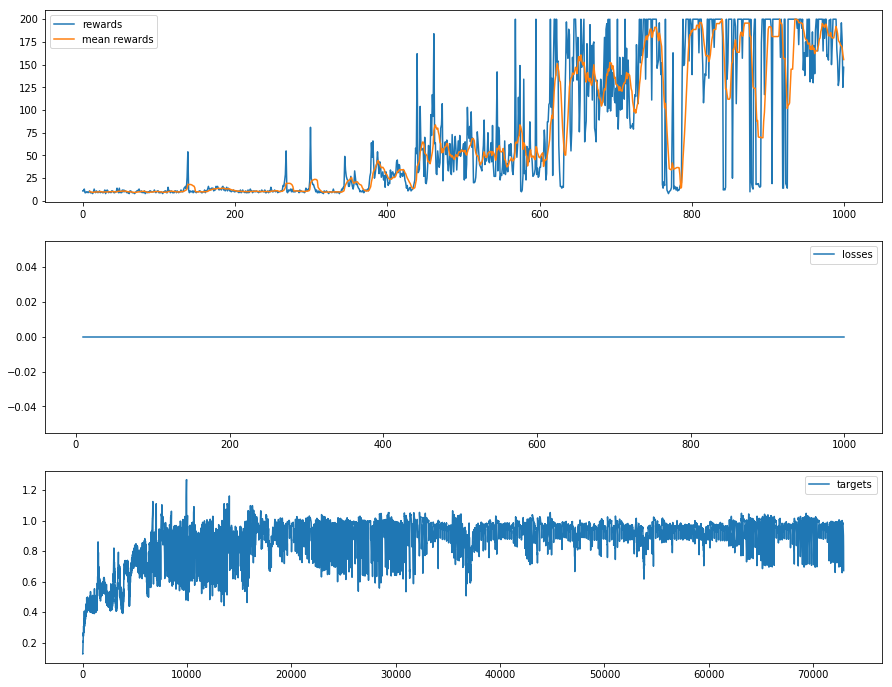

100%|██████████| 1000/1000 [00:49<00:00, 20.03it/s]


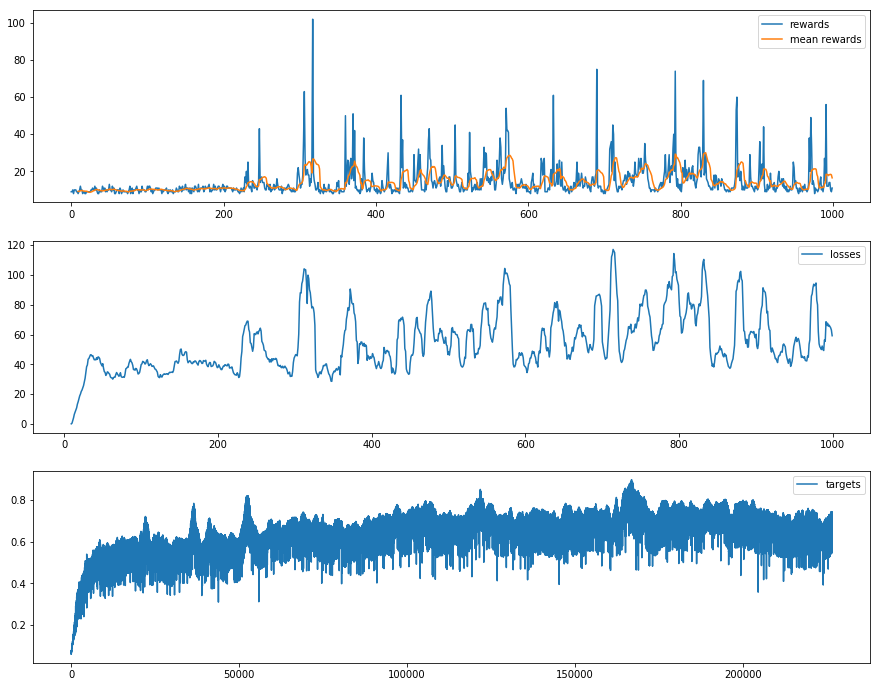

In [2]:
"""
With Deep SARSA Learning
"""


class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(4, 100),
            nn.ReLU(),
            nn.Linear(100, 2))

    def forward(self, xs):
        xs = torch.FloatTensor(xs)
        ys = self.fc(xs)
        return ys

    
def epsilon_greedy_action(policy: nn.Module, state, epsilon) -> Tuple[int, float]:
    action_values = policy(state)
    if np.random.rand(1) < epsilon:
        action = env.action_space.sample()
        return action, action_values[action]
    else:
        action_value, action = torch.max(action_values, dim=-1)
        return action.item(), action_value
    

def train_sarsa_learning(
    env, policy: nn.Module, episodes: int, discount: float,
    learning_rate: float, weight_decay: float,
    epsilon: float,
    show_stats=True):
        
    episode_rewards = []
    episode_losses = []
    targets = []

    criterion = nn.MSELoss()
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    count_success = 0
    for episode in trange(episodes):
        episode_loss = 0.
        episode_reward = 0.
        
        done = False
        state = env.reset()
        action, action_value = epsilon_greedy_action(policy, state, epsilon)
        while not done:
            next_state, reward, done, _ = env.step(action)
            next_action, next_action_value = epsilon_greedy_action(policy, next_state, epsilon)
            
            # Apply the bellman update
            optimizer.zero_grad()
            if not done:
                target = reward + discount * next_action_value.detach()
            else:
                target = torch.tensor(reward)
            loss = criterion(action_value, target)
            loss.backward()
            optimizer.step()
            
            # Moving to next state
            episode_reward += reward
            state = next_state
            action = next_action
            action_value = next_action_value
            targets.append(target)

        # Record history
        episode_rewards.append(episode_reward)
        episode_losses.append(episode_loss)
    
    # Reporting
    if show_stats:
        fig, ax = plt.subplots(figsize=(15, 12), nrows=3)
        ax[0].plot(episode_rewards, label="rewards")
        ax[0].plot(pd.Series(episode_rewards).rolling(10).mean(), label="mean rewards")
        ax[1].plot(pd.Series(episode_losses).rolling(10).sum() / 100., label="losses")
        ax[2].plot(pd.Series(targets).rolling(10).sum() / 100., label="targets")
        for p in ax:
            p.legend()
        plt.show()

        
def train_q_learning(
    env, policy: nn.Module, episodes: int, discount: float,
    learning_rate: float, weight_decay: float,
    epsilon: float,
    show_stats=True):
        
    episode_rewards = []
    episode_losses = []
    targets = []

    criterion = nn.MSELoss()
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    replay_buffer = deque(maxlen=1000)
    
    count_success = 0
    for episode in trange(episodes):
        episode_loss = 0.
        episode_reward = 0.
        
        done = False
        state = env.reset()
        while not done:
            action, action_value = epsilon_greedy_action(policy, state, epsilon)
            next_state, reward, done, _ = env.step(action)
            
            # Storing into the replay buffer
            replay_buffer.append((state, action, next_state, done))
            
            # Extract a mini batch from the replay buffer
            if len(replay_buffer) >= 100:
                losses = []
                for s, a, s2, d in random.choices(replay_buffer, k=16):
                    next_action_values = policy(s2)
                    if not d:
                        next_action_value, _ = torch.max(next_action_values, dim=-1)
                        target = reward + discount * next_action_value.detach()
                    else:
                        target = torch.tensor(reward)
                    losses.append(criterion(action_value, target))
                    targets.append(target)
            
                # Apply the bellman update
                optimizer.zero_grad()
                loss = sum(losses)
                loss.backward()
                optimizer.step()
                episode_loss += loss
            
            # Moving to next state
            episode_reward += reward
            state = next_state

        # Record history
        episode_rewards.append(episode_reward)
        episode_losses.append(episode_loss)
    
    # Reporting
    if show_stats:
        fig, ax = plt.subplots(figsize=(15, 12), nrows=3)
        ax[0].plot(episode_rewards, label="rewards")
        ax[0].plot(pd.Series(episode_rewards).rolling(10).mean(), label="mean rewards")
        ax[1].plot(pd.Series(episode_losses).rolling(10).sum() / 100., label="losses")
        ax[2].plot(pd.Series(targets).rolling(10).sum() / 100., label="targets")
        for p in ax:
            p.legend()
        plt.show()
        
    
"""
Training
"""

with gym.make("CartPole-v0") as env:
    train_sarsa_learning(
        env, policy=PolicyNet(), episodes=1000, discount=0.9,
        learning_rate=1e-3, weight_decay=0.0,
        epsilon=0.1)
    train_q_learning(
        env, policy=PolicyNet(), episodes=1000, discount=0.9,
        learning_rate=1e-3, weight_decay=0.0,
        epsilon=0.1)

 61%|██████    | 1214/2000 [00:48<01:07, 11.72it/s]

Solved!


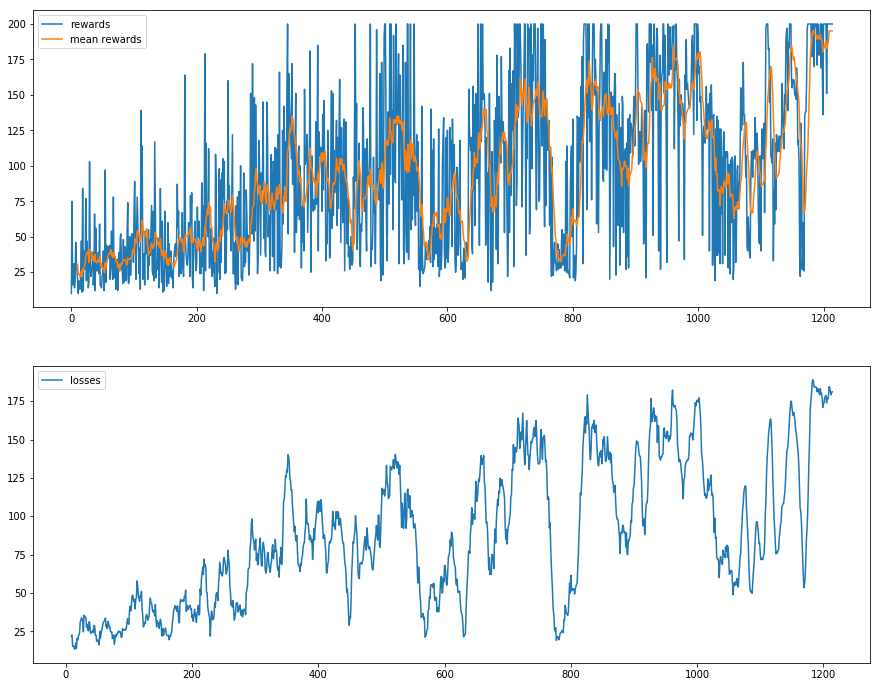

 61%|██████    | 1214/2000 [01:00<01:07, 11.72it/s]

In [7]:
"""
REINFORCE: Monte Carlo Policy Gradient
"""


class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(4, 100),
            nn.ReLU(),
            nn.Linear(100, 2))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, xs, with_softmax=True):
        xs = torch.FloatTensor(xs)
        ys = self.fc(xs)
        if with_softmax:
            ys = self.softmax(ys)
        return ys


def train_reinforce(
    env, policy: nn.Module, episodes: int, discount: float,
    learning_rate: float, weight_decay: float, show_stats=True):
        
    episode_rewards = []
    episode_losses = []

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(policy.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    count_success = 0
    for episode in trange(episodes):
        episode_loss = 0.
        episode_reward = 0.
        
        # Generate a full episode, following the current policy
        moves = []
        done = False
        state = env.reset()
        episode_reward = 0.
        while not done:
            probs = policy(state, with_softmax=True)
            distrib = torch.distributions.categorical.Categorical(probs)
            action = distrib.sample().item()
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            moves.append((state, action, reward))
            state = next_state
        
        # The success criteria
        if episode_reward >= 200.:
            count_success += 1
            if count_success >= 10:
                print("Solved!")
                break
        else:
            count_success = 0
            
        # Add the moves and their outcome in a minibatch
        minibatch = []
        cum_reward = 0.0
        for state, action, reward in reversed(moves):
            cum_reward = reward + discount * cum_reward
            minibatch.append((state, action, cum_reward))
        
        # Optimize the neural net
        policy_losses = []
        for state, action, reward in minibatch:
            probs = policy(state, with_softmax=True)
            prob = probs[action]
            log_prob = torch.log(prob)
            policy_losses.append(- log_prob * reward) # -1 because we want to optimize toward high values
        
        # Adapt weights
        optimizer.zero_grad()
        loss = sum(policy_losses)
        loss.backward()
        optimizer.step()        
        episode_loss = loss.item()

        # Record history
        episode_rewards.append(episode_reward)
        episode_losses.append(episode_loss)
    
    # Reporting
    if show_stats:
        fig, ax = plt.subplots(figsize=(15, 12), nrows=2)
        ax[0].plot(episode_rewards, label="rewards")
        ax[0].plot(pd.Series(episode_rewards).rolling(10).mean(), label="mean rewards")
        ax[1].plot(pd.Series(episode_losses).rolling(10).sum() / 100., label="losses")
        for p in ax:
            p.legend()
        plt.show()
    
    
"""
Training
"""

with gym.make("CartPole-v0") as env:
    train_reinforce(
        env, policy=PolicyNet(), episodes=2000, discount=0.95,
        learning_rate=1e-4, weight_decay=0.0)

 78%|███████▊  | 1569/2000 [01:31<00:44,  9.58it/s]

Solved!


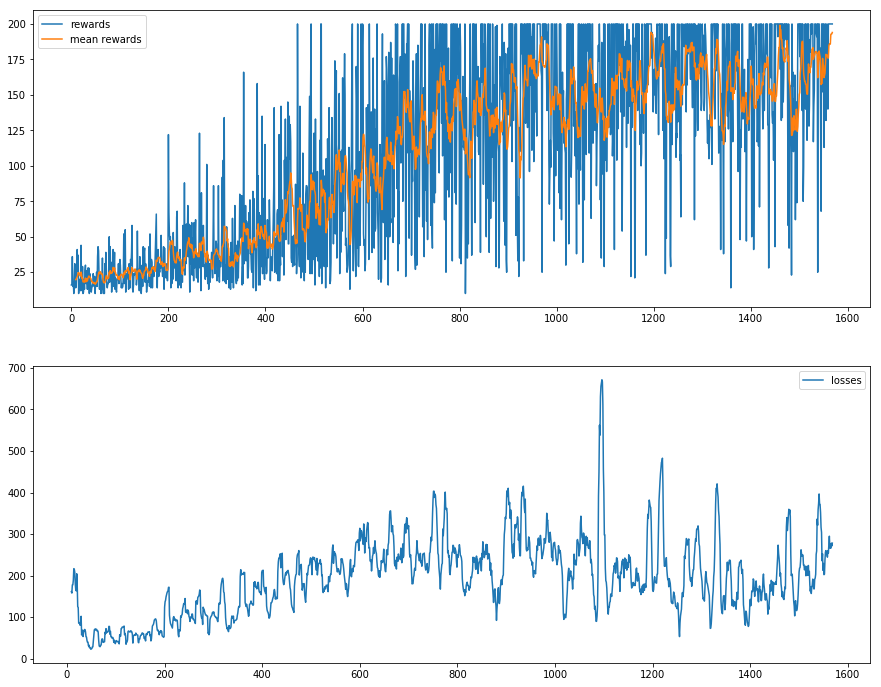

In [5]:
"""
REINFORCE + BASELINE: Monte Carlo Policy Gradient
"""


class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(4, 100),
            nn.ReLU(),
            nn.Linear(100, 3))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, xs, with_softmax=True):
        xs = torch.FloatTensor(xs)
        ys = self.fc(xs)
        if with_softmax:
            return self.softmax(ys[:2]), ys[2:]
        return ys[:2], ys[2:]


def train_reinforce(
    env, policy: nn.Module, episodes: int, discount: float,
    learning_rate: float, weight_decay: float, show_stats=True):
        
    episode_rewards = []
    episode_losses = []

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(policy.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    count_success = 0
    for episode in trange(episodes):
        episode_loss = 0.
        episode_reward = 0.
        
        # Generate a full episode, following the current policy
        moves = []
        done = False
        state = env.reset()
        episode_reward = 0.
        while not done:
            probs, _ = policy(state, with_softmax=True)
            distrib = torch.distributions.categorical.Categorical(probs)
            action = distrib.sample().item()
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            moves.append((state, action, reward))
            state = next_state
        
        # The success criteria
        if episode_reward >= 200.:
            count_success += 1
            if count_success >= 10:
                print("Solved!")
                break
        else:
            count_success = 0
            
        # Add the moves and their outcome in a minibatch
        minibatch = []
        cum_reward = 0.0
        for state, action, reward in reversed(moves):
            cum_reward = reward + discount * cum_reward
            minibatch.append((state, action, cum_reward))
        
        # Optimize the neural net
        value_losses = []
        policy_losses = []
        for state, action, reward in minibatch:
            probs, value = policy(state, with_softmax=True)
            prob = probs[action]
            log_prob = torch.log(prob)
            value_losses.append(torch.pow(reward - value, 2))
            policy_losses.append(- log_prob * (reward - value)) # -1 because we want to optimize toward high values
        
        # Adapt weights
        optimizer.zero_grad()
        loss = sum(policy_losses) + sum(value_losses)
        loss.backward()
        optimizer.step()        
        episode_loss = loss.item()

        # Record history
        episode_rewards.append(episode_reward)
        episode_losses.append(episode_loss)
    
    # Reporting
    if show_stats:
        fig, ax = plt.subplots(figsize=(15, 12), nrows=2)
        ax[0].plot(episode_rewards, label="rewards")
        ax[0].plot(pd.Series(episode_rewards).rolling(10).mean(), label="mean rewards")
        ax[1].plot(pd.Series(episode_losses).rolling(10).sum() / 100., label="losses")
        for p in ax:
            p.legend()
        plt.show()
    
    
"""
Training
"""

with gym.make("CartPole-v0") as env:
    train_reinforce(
        env, policy=PolicyNet(), episodes=2000, discount=0.95,
        learning_rate=1e-4, weight_decay=0.0)